## Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент федерального оператора сотовой связи хочет понять, какой тариф приносит больше денег. Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import seaborn as sns
from functools import reduce

In [8]:
calls_data = pd.read_csv('calls.csv')
internet_data = pd.read_csv('internet.csv')
messages_data = pd.read_csv('messages.csv')
tariffs_data = pd.read_csv('tariffs.csv')
users_data = pd.read_csv('users.csv')

In [9]:
for data in [calls_data, internet_data, messages_data, tariffs_data, users_data]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns

Потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.

In [10]:
tariffs_data.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Замена типа данных

In [11]:
#Заменим тип данных, обозначающих дату, со строчного на временной
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')

## Исправление ошибок в данных

#### Звонки

In [12]:
#Количество звонков с длительностью, равной нулю
calls_data.loc[calls_data['duration'] == 0, 'duration'].value_counts()[0]

39613

In [13]:
# добавим признак со значением месяца
calls_data['month'] = calls_data['call_date'].dt.month

In [14]:
# округлим все значения в большую сторону, т.к. тариф считается по минутам, а нулевые значения заменим на 1
calls_data['duration'] = calls_data['duration'].apply(np.ceil).astype(int)
calls_data.loc[calls_data['duration'] == 0, 'duration'] = 1

In [15]:
calls_data.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,1,1000,7
1,1000_1,2018-08-17,1,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


#### Интернет

In [16]:
# добавим признак со значением месяца
internet_data['month'] = internet_data['session_date'].dt.month

In [17]:
# округлим все значения в большую сторону, т.к. тариф считается по мегабайтам, а нулевые значения заменим на 1
internet_data['mb_used'] = internet_data['mb_used'].apply(np.ceil)
internet_data.loc[internet_data['mb_used'] == 0, 'mb_used'] = 1

### Помесячная выручка с каждого пользователя

In [18]:
# для подсчета при создании сводной таблицы сгенерируем уникальный код из имени и населенного пункта
users_data['unique_name'] = users_data['city'] + users_data['first_name'] + users_data['last_name']

In [19]:
# сводная таблица по звонкам
# добавим столбец со значением месяца
calls_data['month'] = calls_data['call_date'].dt.month
calls_temp = calls_data.merge(users_data, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

In [20]:
# сводная таблица по сообщениям
messages_data['month'] = messages_data['message_date'].dt.month
messages_temp = messages_data.merge(users_data, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

In [21]:
# сводная таблица по интернет-трафику
internet_data['month'] = internet_data['session_date'].dt.month
internet_temp = internet_data.merge(users_data, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

In [22]:
# объединяем все три сводные таблицы в одну
dfs = [calls_grouped, messages_grouped, internet_grouped]
grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)
grouped_data.head(10)

duration  calls  messages  mb_used
user_id month                                    
1000    5         164.0   22.0      22.0   2257.0
        6         187.0   43.0      60.0  23262.0
        7         346.0   47.0      75.0  14017.0
        8         418.0   52.0      81.0  14072.0
        9         478.0   58.0      57.0  14583.0
        10        363.0   57.0      73.0  14717.0
        11        344.0   43.0      58.0  14769.0
        12        341.0   46.0      70.0   9829.0
1001    11        444.0   59.0       NaN  18460.0
        12        430.0   63.0       NaN  14059.0

In [23]:
# пропущенные значения заменяем на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

In [24]:
# добавим наименование используемого тарифа для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users_data.loc[user[0]-1000, 'tariff']

In [25]:
# функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs_data.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs_data.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs_data.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs_data.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs_data.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs_data.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs_data.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs_data.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs_data.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs_data.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs_data.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs_data.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs_data.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs_data.loc[1, 'rub_monthly_fee']
                  )

In [26]:
grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.head(10)

duration  calls  messages  mb_used tariff     revenue
user_id month                                                       
1000    5         164.0   22.0      22.0   2257.0  ultra  1950.00000
        6         187.0   43.0      60.0  23262.0  ultra  1950.00000
        7         346.0   47.0      75.0  14017.0  ultra  1950.00000
        8         418.0   52.0      81.0  14072.0  ultra  1950.00000
        9         478.0   58.0      57.0  14583.0  ultra  1950.00000
        10        363.0   57.0      73.0  14717.0  ultra  1950.00000
        11        344.0   43.0      58.0  14769.0  ultra  1950.00000
        12        341.0   46.0      70.0   9829.0  ultra  1950.00000
1001    11        444.0   59.0       0.0  18460.0  smart  1155.46875
        12        430.0   63.0       0.0  14059.0  smart   550.00000

### Анализ данных

In [27]:
#Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц
means_data = grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='mean')
for user_id in users_data['user_id']:
    means_data.loc[user_id, 'tariff'] = users_data.loc[user_id-1000, 'tariff']
means_data.head()

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,330.125,13438.250000,62.0,1950.000000,ultra
1001,437.000,16259.500000,0.0,852.734375,smart
1002,223.000,16607.857143,10.0,959.151786,smart
1003,782.800,11466.200000,76.0,1950.000000,ultra
1004,128.000,18649.250000,149.0,1950.000000,ultra


In [28]:
#Найдем среднее занчение, дисперсию и стандартное отклонение
means_data.dropna(subset=['duration'], inplace=True)
desc_stat = means_data.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.mean, np.var, np.std], 
                             'mb_used': [np.mean, np.var, np.std], 
                             'messages': [np.mean, np.var, np.std]})
desc_stat

duration                                 mb_used               \
              mean         std           var          mean          std   
tariff                                                                    
smart   431.146966  148.814080  22145.630392  16209.364967  3585.221847   
ultra   541.980498  289.113314  83586.508375  19594.606163  8319.434812   

                       messages                          
                 var       mean        std          var  
tariff                                                   
smart   1.285382e+07  32.352078  26.512448   702.909910  
ultra   6.921300e+07  54.030743  46.366246  2149.828793

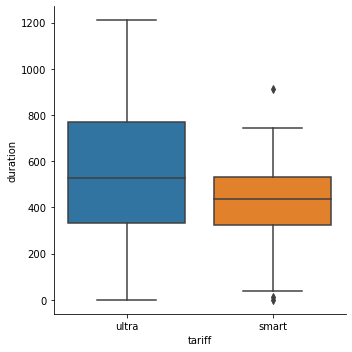

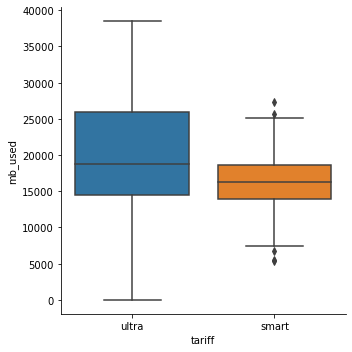

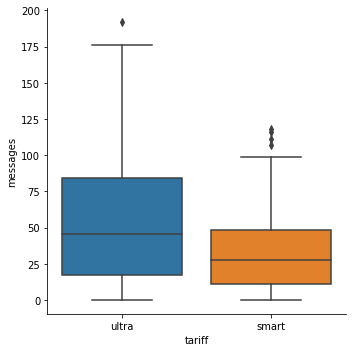

In [29]:
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=means_data, orient='v')

Минуты разговора, сообщения и объем интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и среднее значение также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

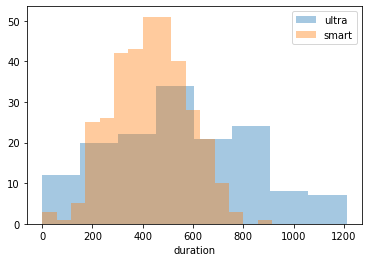

In [30]:
for tariff in ['ultra', 'smart']:
    sns.distplot(means_data.query('tariff == @tariff')['duration'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])

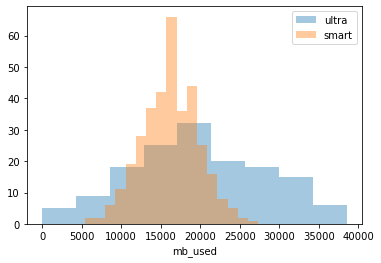

In [31]:
for tariff in ['ultra', 'smart']:
    sns.distplot(means_data.query('tariff == @tariff')['mb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])

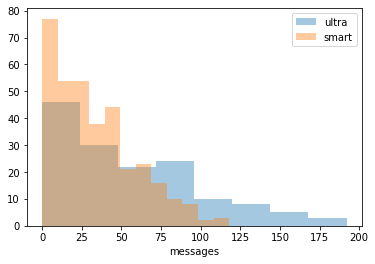

In [32]:
for tariff in ['ultra', 'smart']:
    sns.distplot(means_data.query('tariff == @tariff')['messages'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])

По гистограммам видно, что дисперсия по тарифу «Смарта» меньше, чем у пользователей с тарифом «Ультра». Также на гистограммах видно, что мода у «Смарта» явно выражена.

- Пользователи тарифа «Смарт» часто не вклиниваются в лимиты: по кол-ству минут и по лимиту мегабайт
- Пользователи тарифа «Ультра» практически не превышают лимитов, кроме интернета. Возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора
- Пользователи обоих тарифоф довольно редко пользуются отправкой сообщений.

### Проверка гипотез

H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H1 — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

α = 5%

In [33]:
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .05

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.4535744400867116e-281
Отвергаем нулевую гипотезу


In [34]:
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='mean')

,revenue
tariff,
smart,1251.409667
ultra,2060.591390


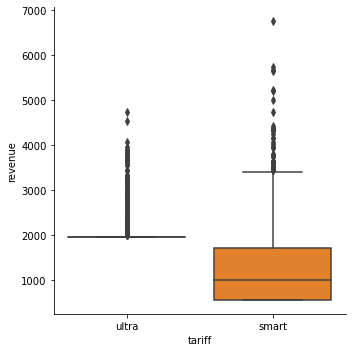

In [35]:
_ = sns.catplot(x="tariff", y='revenue', kind="box", data=grouped_data, orient='v')

Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего к концу месяца заплатит гораздо больше из-за нехватки услуг.

__________________________________________________________________________________________________________________

H0 — средняя выручка по г. Москва равна средней выручке других регионов.

H1 — средняя выручка по г. Москва отличается от средней выручки других регионов.

α = 5%

In [36]:
# добавим наименование населенного пункта для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users_data.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .05

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5030013194608627
Не получилось отвергнуть нулевую гипотезу


In [37]:
def det_region(city):
    if city == 'Москва':
        return 'Москва'
    else:
        return 'Другой регион'
    
grouped_data['region'] = grouped_data['city'].apply(det_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='mean')

,revenue
region,
Другой регион,1495.094552
Москва,1517.747216


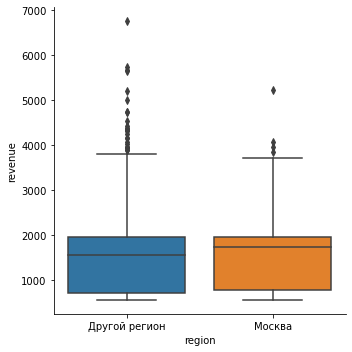

In [38]:
_ = sns.catplot(x="region", y='revenue', kind="box", data=grouped_data, orient='v')

Доходы по г. Москва практически не отличаются от других населенных пунктов.

### Общий вывод

По результатам анализа доходы по тарифу «Ультра» больше, чем по тарифу «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 2060 рублей и 1251 рублей.

- Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 701 рубль ежемесячно.
- Пользователи тарифа «Ультра», наоборот, не используют тарифный пакет в полном объеме.
- Средние доходы по г. Москва не отличаются от доходов других населенных пунктах: разница статистически незначима (p-значение: 0,503) и составляет 23 руб.: 1517 руб. в Москве против 1495 руб. в других населенных пунктах.
- Пользователи больше предпочитают тариф «Смарт», 351 против 149.
- Объем дополнительного дохода больше у тарифа «Смарт».
- Самым прибильным сегментом является - интернет, при том в двух тарифах.
- Общая прибыль больше у тарифа «Смарт».
- Несмотря на то, что больше прибыли приносит тариф «Смарт», среднняя выручка выше у «Ультра».